# Apply machine learning on a spherical subdomain

## Authors & Contributors

### Authors

- Jean-Marc Delouis, LOPS - Laboratoire d'Oceanographie Physique et Spatiale UMR 6523 CNRS-IFREMER-IRD-Univ.Brest,
- Tina Odaka, Laboratoire d'Oceanographie Physique et Spatiale UMR 6523 CNRS-IFREMER-IRD-Univ.Brest,
- Justus Mangin, Laboratoire d'Oceanographie Physique et Spatiale UMR 6523 CNRS-IFREMER-IRD-Univ.Brest,

## Context

This notebook demonstrates the use of the **FOSCAT** package to produce machine learning statistical information on a subdomain of the sphere. While the ability to work on a global domain has already been demonstrated, this version uses the **healpix-convolution** package, which is designed to perform local convolutions on the sphere efficiently. Previously, the **FOSCAT** package worked with the HEALPix grid, but convolutions were always performed over the full domain. In contrast, the use of the **healpix-convolution** package, also using HEALPix grid, now enables efficient local convolutions and allows working with very high-resolution HEALPix grids ($N_{\text{side}} \gg 512$).

### Workflow Steps

The goal here is to showcase **FOSCAT**’s ability to operate on a limited domain—specifically, a coastal region in Sea Surface Temperature data. The initial steps demonstrate smoothing and wavelet decomposition of the signal. Subsequent steps illustrate **FOSCAT**’s capability to compute the spherical **scattering covariance** [1] on this localized domain.

### For further details, please refer to:

[1] Mousset, L., Allys, E., Pric, M. A., Aumo, J., Delouis, J.-M., Montier, L., McEwen, J. D., *Submitted 2024, Astronomy & Astrophysics*.

## What is HEALPix

HEALPix stands for Hierarchical Equal Area isoLatitude Pixelation of a sphere. This pixelation produces a subdivision of a spherical surface in which each pixel covers the same surface area as every other pixel. 
![HEALPix](https://healpix.sourceforge.io/images/gorski_f1.jpg)

See [https://healpix.sourceforge.io](https://healpix.sourceforge.io) and/or [the HEALPix Primer](https://healpix.jpl.nasa.gov/pdf/intro.pdf) for more information.

The [healpy tutorial](https://healpy.readthedocs.io/en/latest/tutorial.html#NSIDE-and-ordering) is also a very good starting point to understand more about HEALPix.

### Resolution
The resolution of the grid is expressed by the parameter `$N_{side}$`, which defines the number of divisions along the side of a base-resolution pixel that is needed to reach a desired high-resolution partition.

### Ordering Systems

HEALPix supports two pixel ordering systems: `nested` and `ring`.

Detailed explanations of the two pixel ordering systems can be found at [https://healpix.jpl.nasa.gov/html/intronode4.htm](https://healpix.jpl.nasa.gov/html/intronode4.htm).

| nside   | Resolution (arcmin) | Pixel size (km) |
|---------|---------------------|------------------|
| 1       | 3437.75             | 3826             |
| 2       | 1718.87             | 1913             |
| 4       | 859.44              | 957              |
| 8       | 429.72              | 478              |
| 16      | 214.86              | 239              |
| 32      | 107.43              | 120              |
| 64      | 53.71               | 60               |
| 128     | 26.85               | 30               |
| 256     | 13.43               | 15               |
| 512     | 6.71                | 7.5              |
| 1024    | 3.36                | 3.7              |
| 2048    | 1.68                | 1.8              |
| 4096    | 0.84                | 0.9              |
| 8192    | 0.42                | 0.45             |
| 16384   | 0.21                | 0.22             |
| 32768   | 0.10                | 0.11             |
| 65536   | 0.05                | 0.055            |

### choose the resolution

we use $nside=2048$ in this context to prevent excessive computation we use the `nested`ordering.

### Get the proper packages

In [1]:
!pip uninstall foscat -y
!pip install git+https://github.com/jmdelouis/FOSCAT.git@Test_cnn

  Cloning https://github.com/jmdelouis/FOSCAT.git (to revision Test_cnn) to /tmp/pip-req-build-i05npd9a
  Running command git clone --filter=blob:none --quiet https://github.com/jmdelouis/FOSCAT.git /tmp/pip-req-build-i05npd9a
  Running command git checkout -b Test_cnn --track origin/Test_cnn
  Switched to a new branch 'Test_cnn'
  Branch 'Test_cnn' set up to track remote branch 'Test_cnn' from 'origin'.
  Resolved https://github.com/jmdelouis/FOSCAT.git to commit 7662a97fb2049c0c916c71e35feac133e205457b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached spherical-1.0.15-py3-none-any.whl.metadata (7.7 kB)
  Using cached quaternionic-1.0.15-py3-none-any.whl.metadata (18 kB)
  Using cached spinsfast-2022.4.10-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (520 bytes)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 14.8 MB/s eta 0:00:0000:0100:01
Using cached sphe

In [2]:
!pip uninstall healpix-convolution -y
!pip install git+https://github.com/IAOCEA/healpix-convolution.git@WaveletComputation

  Cloning https://github.com/IAOCEA/healpix-convolution.git (to revision WaveletComputation) to /tmp/pip-req-build-vv0hvanu
  Running command git clone --filter=blob:none --quiet https://github.com/IAOCEA/healpix-convolution.git /tmp/pip-req-build-vv0hvanu
  Running command git checkout -b WaveletComputation --track origin/WaveletComputation
  Switched to a new branch 'WaveletComputation'
  Branch 'WaveletComputation' set up to track remote branch 'WaveletComputation' from 'origin'.
  Resolved https://github.com/IAOCEA/healpix-convolution.git to commit 46c1896be6f7914742dcad17f93daf5d87495cfa
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached cdshealpix-0.7.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.3 kB)
  Using cached healpix_geo-0.0.2-cp312-cp312-manylinux_2_34_x86_64.whl.metadata (560 bytes)
  Using cached xdggs-0.2.0-py3-none-any.whl.metadata (5.2 kB)
  

In [3]:
import numpy as np
import foscat.scat_cov as sc
import matplotlib.pyplot as plt
import sys
import healpy as hp
import foscat.Synthesis as synthe
import xarray as xr

### Call the data

The data are into a zarr file in order to make them easy to analyse and compute.

In [4]:
dtotal=xr.open_zarr('data/test.zarr')
dtotal

<xarray.Dataset> Size: 90MB
Dimensions:    (depth: 8, latitude: 180, longitude: 324, time: 24)
Coordinates:
  * depth      (depth) float32 32B 0.494 1.541 2.646 3.819 ... 6.441 7.93 9.573
  * latitude   (latitude) float32 720B 46.03 46.05 46.08 ... 50.94 50.97 51.0
  * longitude  (longitude) float32 1kB -7.999 -7.971 -7.944 ... 0.9456 0.9733
  * time       (time) datetime64[ns] 192B 2025-03-20 ... 2025-03-20T23:00:00
Data variables:
    thetao     (time, depth, latitude, longitude) float64 90MB dask.array<chunksize=(1, 1, 180, 324), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.8
    comment:      
    contact:      https://marine.copernicus.eu/contact
    institution:  NOW Systems (Spain)
    references:   http://marine.copernicus.eu/
    source:       NEMO3.6
    title:        Ocean 3D hourly mean fields for the Iberia-Biscay-Ireland (...

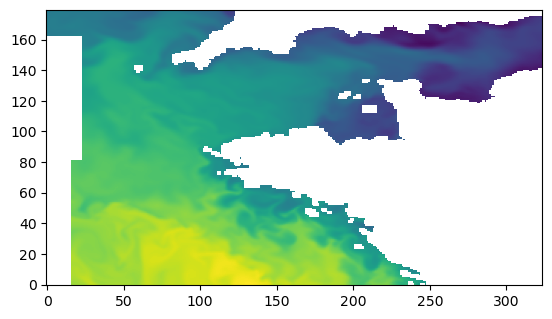

In [5]:
# plot the data
plt.imshow(dtotal.thetao.compute().values[12,0],origin='lower')

### Convert the data to HEALPix

Here, to convert the data onto a HEALPix grid, we use a 2D interpolation based on the HEALPix indices corresponding to the input grid. 

One of the main difficulties lies in the fact that the input grid is affected by **local tangential distortions**, which can lead to some HEALPix pixels not being sampled. 

To address this issue, we apply a small trick to ensure that **all relevant HEALPix pixels are selected**, even in regions where the mapping might otherwise miss some.

In [6]:
# Define the HEALPix resolution
nside = 2048

# Get the data, longitude, and latitude
data = dtotal.thetao.compute().values[12, 0, :, :]
longitude = np.tile(dtotal.longitude.compute().values, data.shape[0])
latitude = np.repeat(dtotal.latitude.compute().values, data.shape[1])

#
# Filter out invalid (NaN) inputs
idx = np.where(~np.isnan(data.flatten()))[0]
data = data.flatten()

# Compute the corresponding HEALPix cell indices at nside=1024 to ensur the computation of all pixel at higher resolution
input_cell_ids = hp.ang2pix(1024, -longitude, latitude, lonlat=True, nest=True)
if nside>1024:
    input_cell_ids = (nside//1024)**2*np.repeat(input_cell_ids,(nside//1024)**2)+np.tile(np.arange((nside//1024)**2),input_cell_ids.shape[0])
    
input_cell_ids = np.unique(input_cell_ids)

# Interpolate values from the original grid
from scipy.interpolate import griddata

# Get the coordinates of the HEALPix pixel centers in the original grid
lon, lat = hp.pix2ang(nside, input_cell_ids, lonlat=True, nest=True)

# Create the coordinate array of the original data points
points = np.column_stack((longitude, latitude))

# Perform bicubic interpolation
grid_z = griddata(points, data, (-lon, lat), method='linear')

# Filter out NaNs from interpolation results
cell_ids = input_cell_ids[~np.isnan(grid_z)]
data = grid_z[~np.isnan(grid_z)]

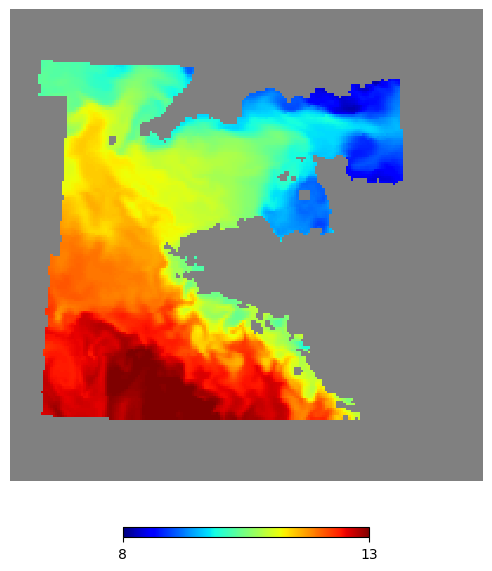

In [7]:
def plot_result(data,cell_ids,nside,hold=None,sub=None,title=None,unit=None,vmin=None,vmax=None):
    im=np.ones([12*nside**2])*hp.UNSEEN
    im[cell_ids]=data
    if vmin is None:
        vmin=data.min()
    if vmax is None:
        vmax=data.max()
    hp.gnomview(im,cmap='jet',nest=True,rot=[3.4,48.5],reso=2,hold=hold,sub=sub,notext=True,title=title,unit=unit,min=vmin,max=vmax)

plot_result(data,cell_ids,nside,vmin=8,vmax=13)

# Load the **FOSCAT** package

This command initializes all necessary components.

In this demo, the backend used is **Torch**. The **TensorFlow** backend is not yet optimized for local HEALPix operations.

In [8]:
scat=sc.funct(BACKEND='torch')

/srv/conda/envs/notebook/lib/python3.12/site-packages/foscat/BkTorch.py:139: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1718580740865/work/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  .to_sparse_csr()


### Use **FOSCAT** to smooth the data

To perform multiscale computations, **FOSCAT** requires an initial smoothing step. This step is demonstrated here.

An important point to note is the use of padding, which ensures proper smoothing at the boundaries of the field.

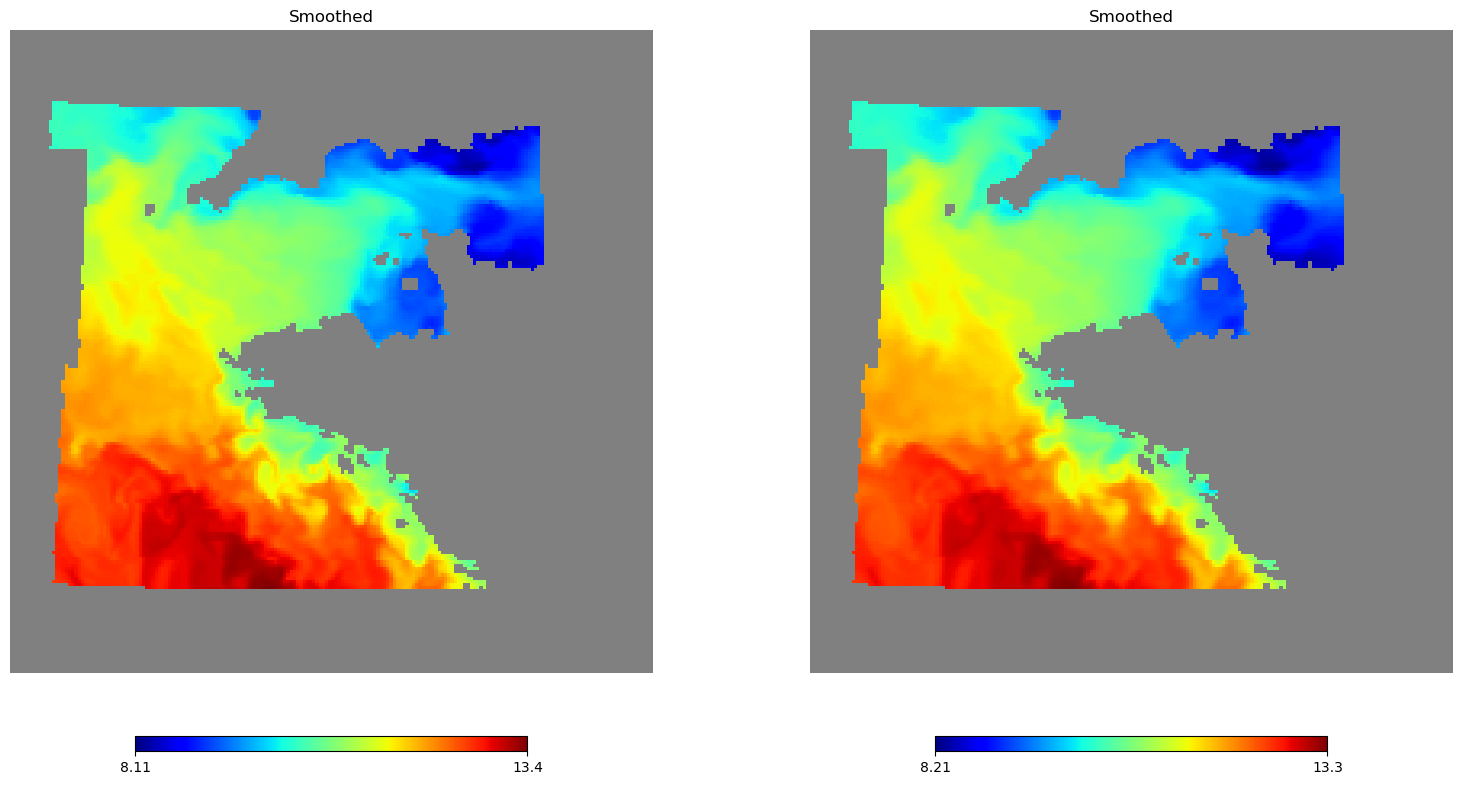

In [9]:
#compute smoothed image
smoothed_image = scat.smooth(scat.backend.bk_cast(data[None,:]),cell_ids=cell_ids,nside=nside)

#plot smoothed and unsmoothed images
plt.figure(figsize=(16,8))
plot_result(data,cell_ids,nside,hold=False,sub=(1,2,1),title='Smoothed')
plot_result(smoothed_image.cpu().numpy()[0,:].real,cell_ids,nside,hold=False,sub=(1,2,2),title='Smoothed')

### Use FOSCAT to compute the wavelet decomposition

The core of the Scattering Covariance method is the computation of the wavelet decomposition. **FOSCAT** provides tools to perform this operation, and the next cell shows the result for a directional wavelet at the smallest scale, denoted as $J_0$. The number of orientations is 4 ($\Theta_0, \dots, \Theta_3$).

The Morlet wavelet used in **FOSCAT** has both a real and an imaginary part. The following rows display these two components, along with the norm of the complex coefficients.


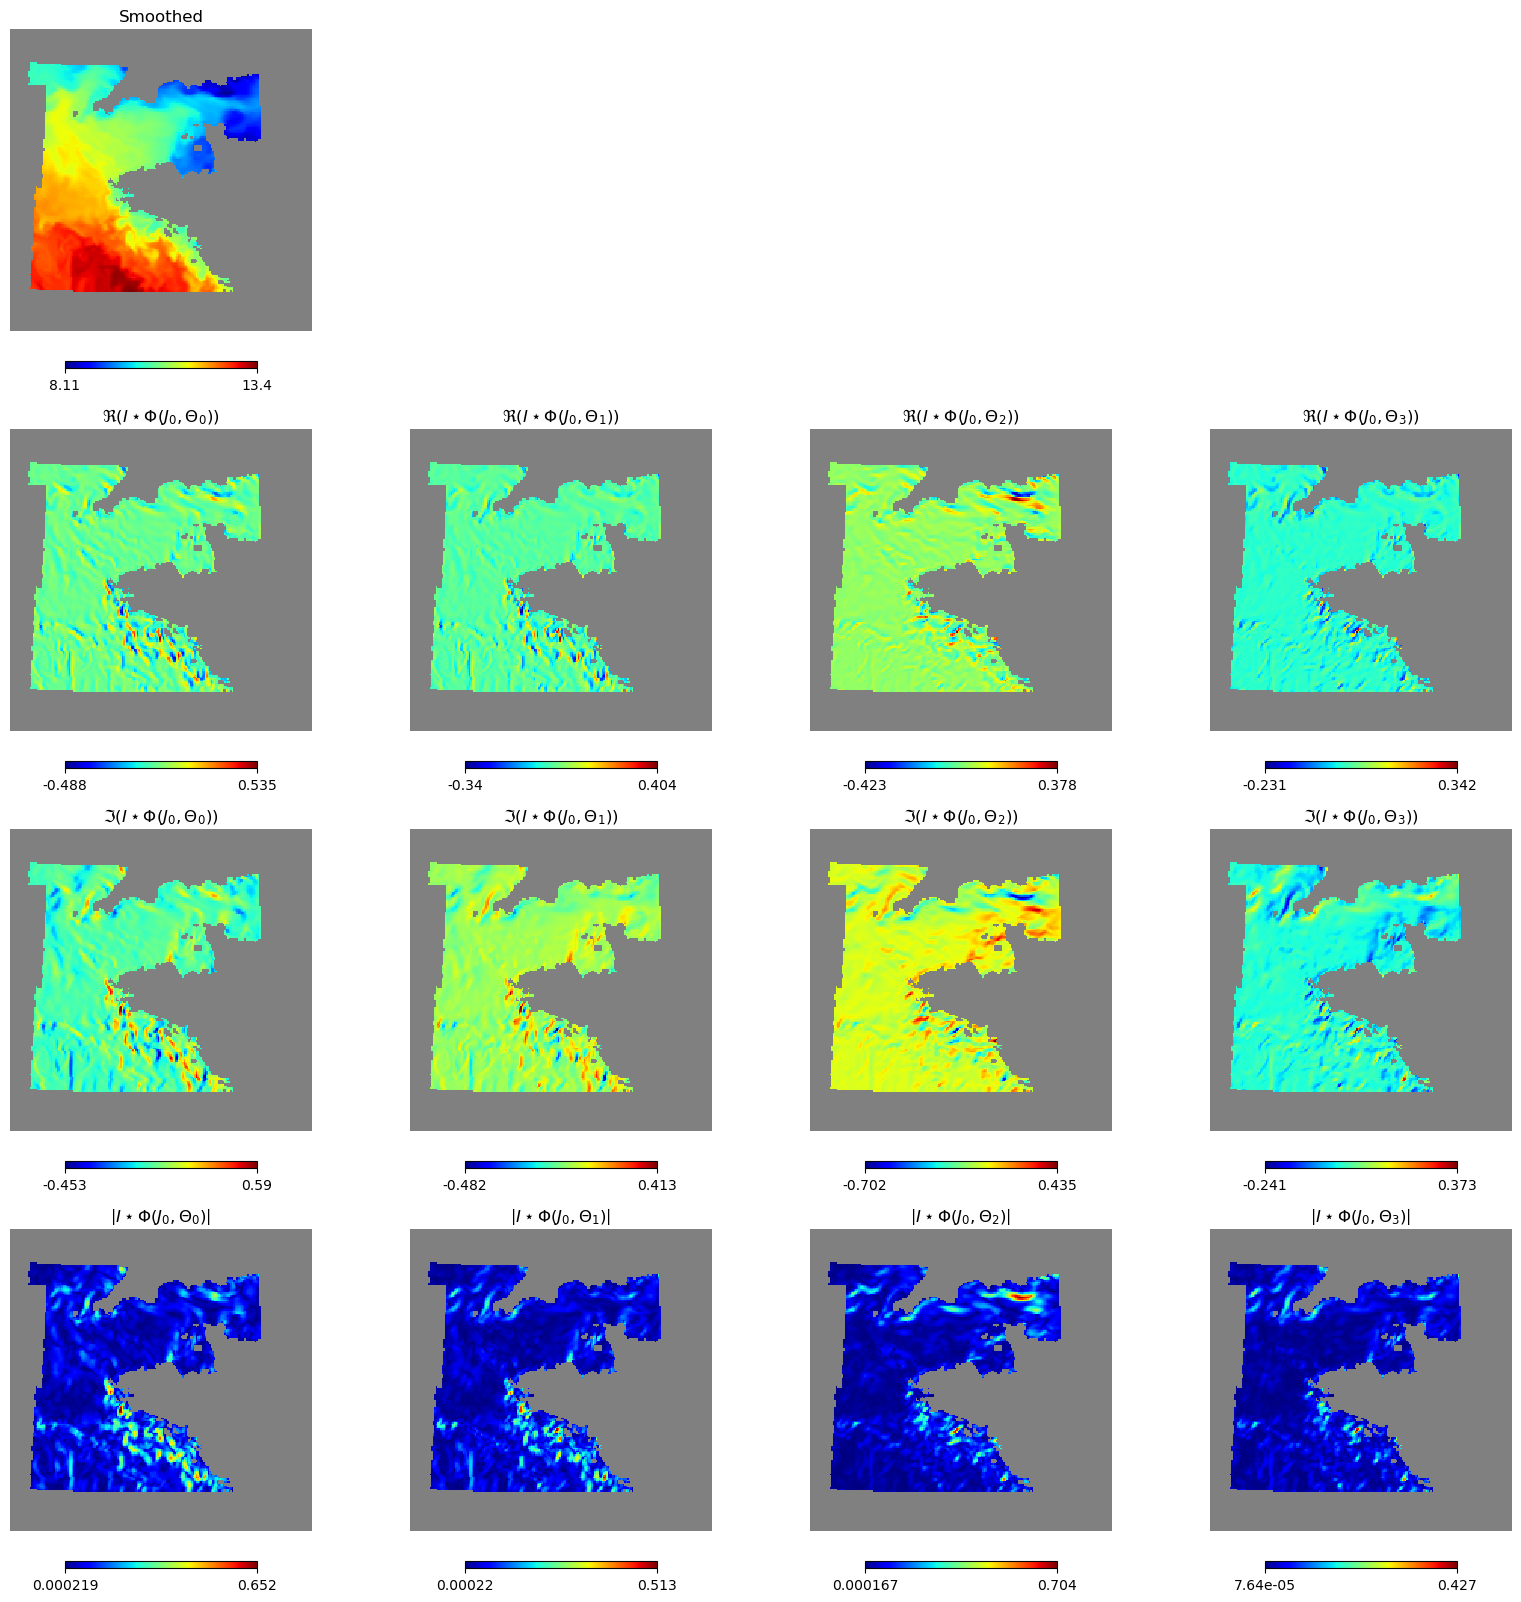

In [10]:
#compute wavelet image
smoothed_image = scat.convol(scat.backend.bk_cast(data[None,:]),cell_ids=cell_ids,nside=nside)

#plot smoothed and unsmoothed images
plt.figure(figsize=(16,16))
plot_result(data,cell_ids,nside,hold=False,sub=(4,4,1),title='Smoothed')
for k in range(4):
    plot_result(smoothed_image.cpu().numpy()[0,:,k].real,cell_ids,nside,hold=False,sub=(4,4,5+k),
                title=r'$\Re\left(I\star\Phi(J_0,\Theta_%d)\right)$'%(k))
    plot_result(smoothed_image.cpu().numpy()[0,:,k].imag,cell_ids,nside,hold=False,sub=(4,4,9+k),
                title=r'$\Im\left(I\star\Phi(J_0,\Theta_%d)\right)$'%(k))
    plot_result(abs(smoothed_image.cpu().numpy()[0,:,k]),cell_ids,nside,hold=False,sub=(4,4,13+k),
                title=r'$\left|I\star\Phi(J_0,\Theta_%d)\right|$'%(k))

The next cell shows the wavelet decomposition across multiple scales. Each successive scale $j_1, \dots, J_4$ corresponds to a larger spatial scale and is computed at a lower resolution.

This computation—and the definition itself—is efficient when using the 'nested' ordering, as downsampling an image simply involves averaging the values of the four child `cell_ids` from the higher resolution.

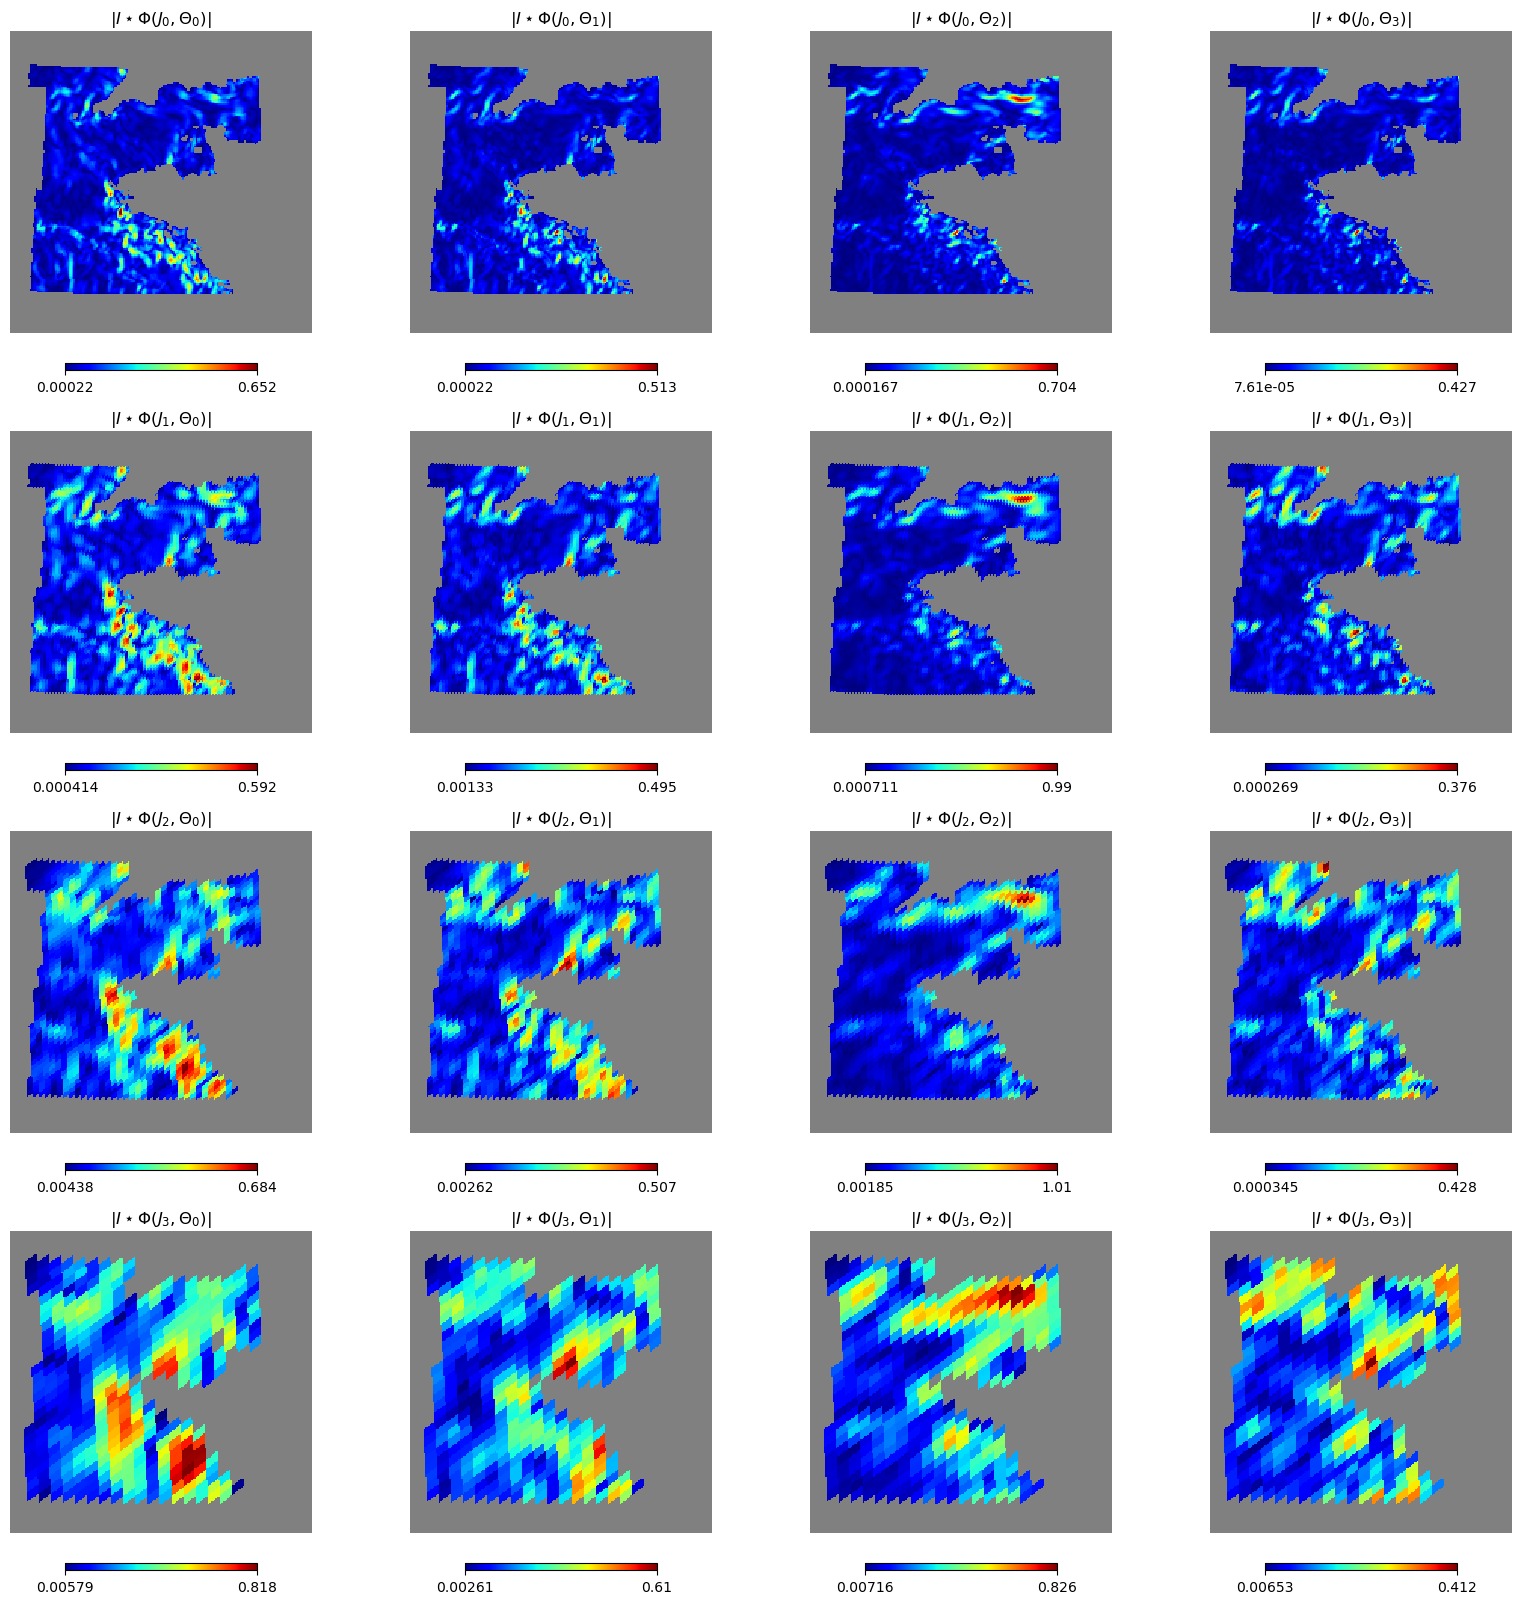

In [11]:
l_data=scat.backend.bk_cast(data[None,:]-np.median(data))

plt.figure(figsize=(16,16))
l_nside=nside
l_cell_ids=cell_ids.copy()
nscale=4
for l in range(nscale):
    wave=scat.convol(l_data,cell_ids=l_cell_ids,nside=l_nside)
    for k in range(4):
        plot_result(abs(wave.cpu().numpy()[0,:,k]),l_cell_ids,l_nside,hold=False,
                    sub=(nscale,4,1+k+4*l),unit='',title=r'$|I\star\Phi(J_%d,\Theta_%d)|$'%(l,k))
    l_data=scat.smooth(l_data,cell_ids=l_cell_ids,nside=l_nside)
    l_data,l_cell_ids=scat.ud_grade_2(l_data,cell_ids=l_cell_ids,nside=l_nside)
    l_nside//=2

### Use FOSCAT to compute the Scattering Covariance

The next cell demonstrates how to estimate the Scattering Covariance (SC) of the input data compared to white noise. The resulting plot of the SC coefficients clearly shows that the dynamics of the sea surface temperature (SST) are far from resembling white noise — a distinction that is clearly identifiable.

In the next section, this notebook illustrates how to use these statistical properties to synthesize data that reproduces the same statistics, starting from white noise.

In [12]:
scat_in=scat.eval(data-np.median(data),Jmax=5,cell_ids=cell_ids,nside=nside)
scat_noise=scat.eval(np.random.randn(data.shape[0])*np.std(data),Jmax=5,cell_ids=cell_ids,nside=nside)

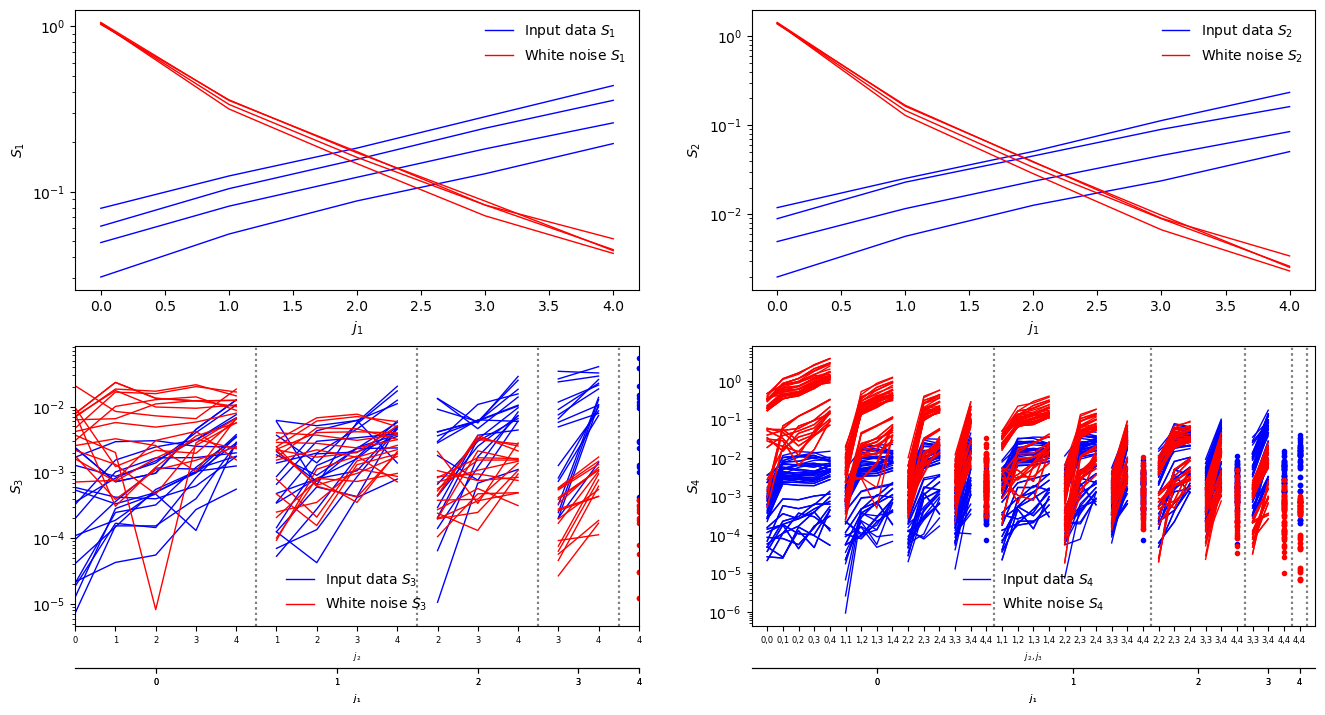

In [13]:
scat_in.plot(color='b',name='Input data')
scat_noise.plot(hold=False,color='r',name='White noise')

# Synthesize data using **FOSCAT**

The synthesis process using **FOSCAT** is documented in other notebooks. Here, the focus is on working with a reduced number of `cell_ids` over a limited domain. This is particularly important in Earth observation, where spatial resolution can be very high, and large-scale correlations are critical. For this reason, the synthesis should be performed on a spherical grid.

### The Method

* **Step 1**: The user must define a loss function. In this example, the loss is the quadratic difference between the SC (Scattering Covariance) coefficients of the synthesized map and those of the original data.
* **Step 2**: The reference SC coefficients and their variances are computed over the target data domain. These variances are then used to weight each coefficient in the loss function.
* **Step 3**: The synthesis is performed using an **L-BFGS** algorithm based on gradient descent.

In [14]:
# step 1

def The_loss(u,scat_operator,args):
    ref  = args[0]
    sref = args[1]
    cell_ids =args[2]
    nside = args[3]

    # compute scattering covariance of the current synthetised map called u
    learn=scat_operator.eval(u,norm='self',cell_ids=cell_ids,nside=nside,Jmax=5)

    # make the difference withe the reference coordinates
    loss=scat_operator.reduce_distance(learn,ref,sigma=sref)

    return(loss)

In [15]:
# step 2

ref,sref=scat.eval(data-np.median(data),Jmax=5,cell_ids=cell_ids,nside=nside,calc_var=True)

loss=synthe.Loss(The_loss,scat,ref,sref,cell_ids,nside)

sy = synthe.Synthesis([loss])

In [16]:
# step 3

imap=np.random.randn(1,data.shape[0])*np.std(data)

omap=scat.to_numpy(sy.run(imap,
            EVAL_FREQUENCY=30,
            NUM_EPOCHS = 1000))

Total number of loss  1
Itt      0 L=  1.51e+07 (  1.51e+07 ) 4.787s 
Itt     30 L=       198 (       198 ) 153.615s 
Itt     60 L=      29.8 (      29.8 ) 143.954s 
Itt     90 L=      15.4 (      15.4 ) 158.039s 
Itt    120 L=      10.1 (      10.1 ) 152.982s 
Itt    150 L=      7.66 (      7.66 ) 156.894s 
Itt    180 L=      6.02 (      6.02 ) 165.923s 
Itt    210 L=       4.9 (       4.9 ) 161.968s 
Itt    240 L=      4.25 (      4.25 ) 155.727s 
Itt    270 L=      3.72 (      3.72 ) 169.022s 
Itt    300 L=       3.3 (       3.3 ) 159.175s 
Itt    330 L=      2.98 (      2.98 ) 173.014s 
Itt    360 L=      2.64 (      2.64 ) 174.679s 
Itt    390 L=      2.39 (      2.39 ) 149.688s 
Itt    420 L=      2.19 (      2.19 ) 167.879s 
Itt    450 L=      2.02 (      2.02 ) 155.518s 
Itt    480 L=      1.89 (      1.89 ) 143.643s 
Itt    510 L=      1.79 (      1.79 ) 145.733s 
Itt    540 L=      1.69 (      1.69 ) 148.515s 
Itt    570 L=      1.58 (      1.58 ) 161.773s 
Itt    600 L=     

### Plot the result

The synthesized data is not identical to the target, but it exhibits similar statistical behavior.


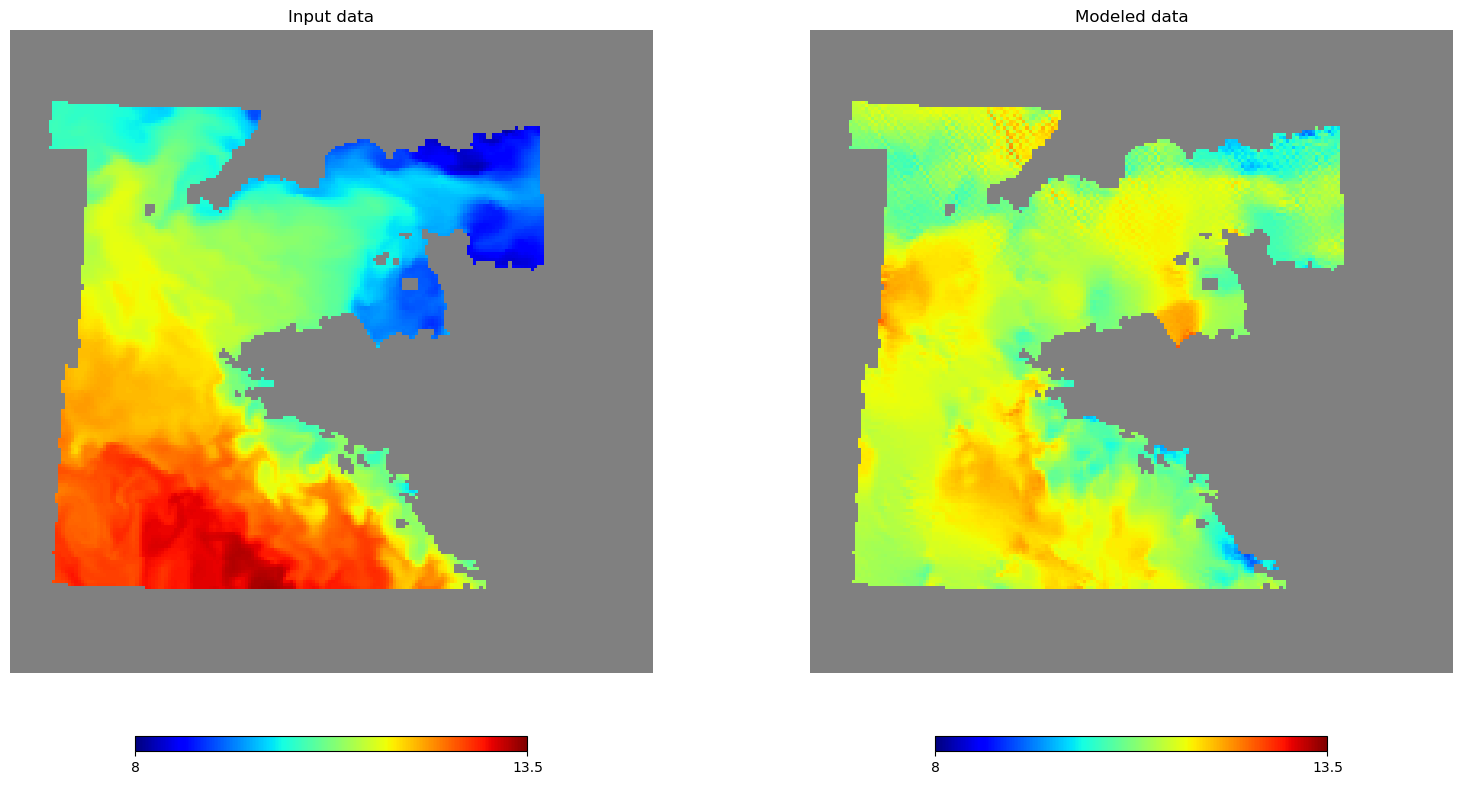

In [17]:
plt.figure(figsize=(16,8))
plot_result(data,cell_ids,nside,hold=False,sub=(1,2,1),title='Input data',vmin=8,vmax=13.5)
plot_result(omap+np.median(data),cell_ids,nside,hold=False,sub=(1,2,2),title='Modeled data',vmin=8,vmax=13.5)